# HUDF Analysis with SEP

In this notebook I process a Hubble Ultra Deep Field (HUDF) image using SEP (Source Extraction and Photometry). I load the FITS file, subtract the background, detect sources, apply a detection threshold, visualize segmentation maps, and measure basic photometric properties.

This notebook follows the same structure as Notebook 1 but uses a HUDF field instead of the SEP tutorial image.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sep

plt.rcParams['figure.figsize'] = (8, 8)


## Load HUDF FITS Image

Make sure the HUDF FITS file is in the same directory as this notebook.
Replace `"h udf.fits"` with the correct file name.


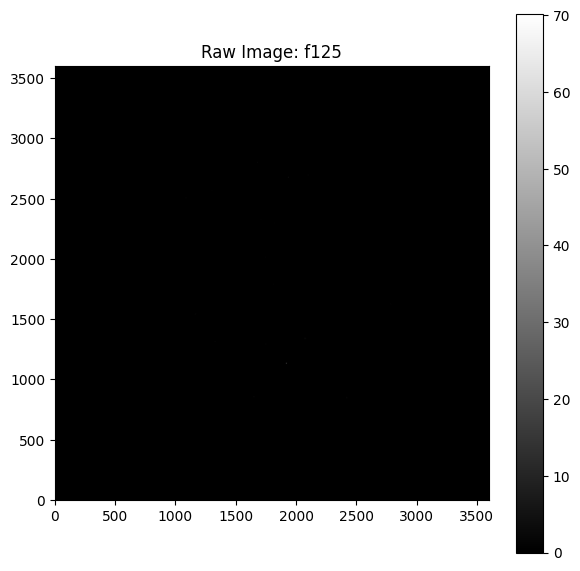

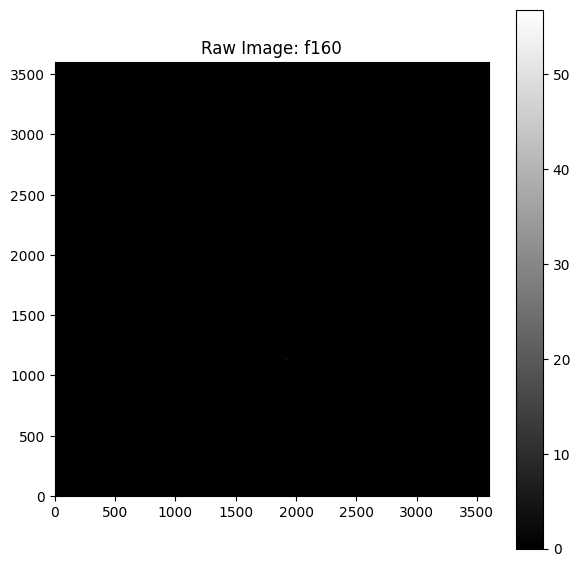

In [7]:
# Load both HUDF filters
files = ["f125", "f160"]

images = {}
for fname in files:
    with fits.open(fname) as hdul:
        images[fname] = hdul[0].data.astype(np.float32)

# Quick display
for fname, data in images.items():
    plt.figure(figsize=(7,7))
    plt.imshow(data, cmap='gray', origin='lower')
    plt.title(f"Raw Image: {fname}")
    plt.colorbar()
    plt.show()


## Background Subtraction

SEP models and subtracts the background for each filter separately.


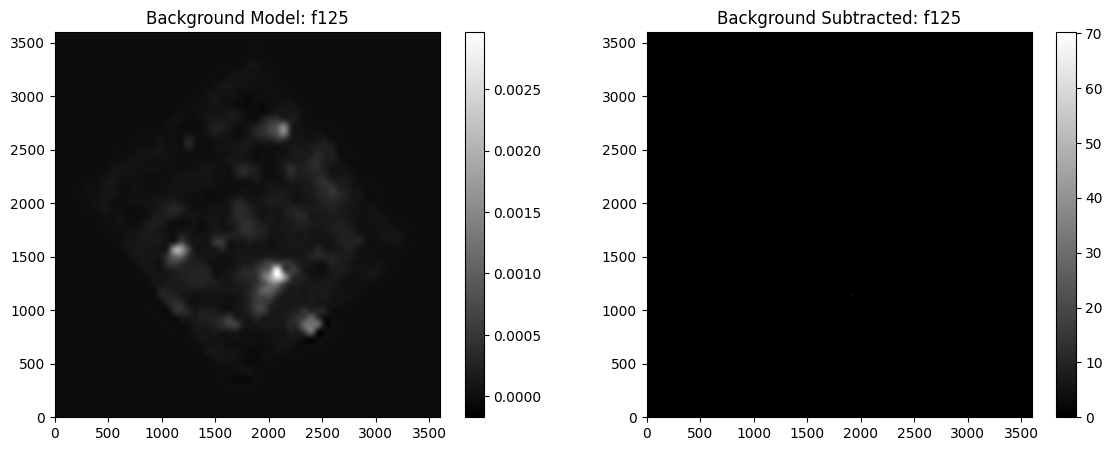

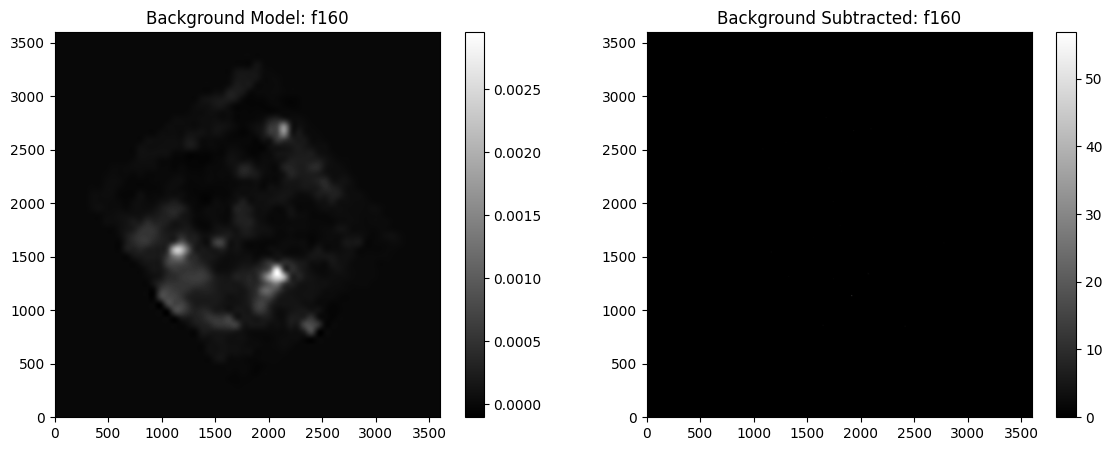

In [8]:
backgrounds = {}
subtracted = {}

for fname, data in images.items():
    bkg = sep.Background(data)
    backgrounds[fname] = bkg
    subtracted[fname] = data - bkg

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.imshow(bkg.back(), cmap='gray', origin='lower')
    plt.title(f"Background Model: {fname}")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(subtracted[fname], cmap='gray', origin='lower')
    plt.title(f"Background Subtracted: {fname}")
    plt.colorbar()
    plt.show()


## Source Detection in Each Filter

We use a 1.5σ threshold to capture faint HUDF galaxies.


In [9]:
detections = {}

for fname, data_sub in subtracted.items():
    bkg = backgrounds[fname]
    objects = sep.extract(data_sub, thresh=1.5, err=bkg.globalrms)
    detections[fname] = objects
    
    print(f"{fname}: detected {len(objects)} sources")


f125: detected 7495 sources
f160: detected 7652 sources


## Visualizing Detected Sources

This overlays detection markers on the background-subtracted images.


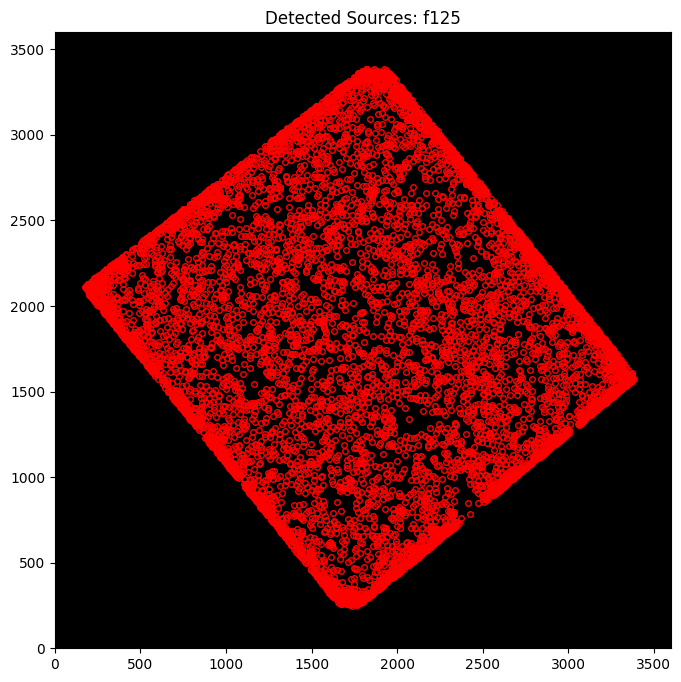

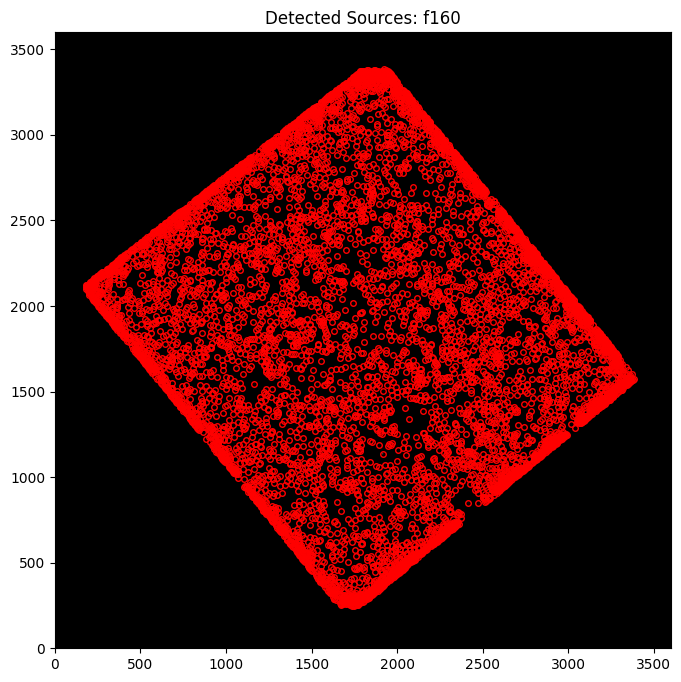

In [10]:
for fname, data_sub in subtracted.items():
    objects = detections[fname]

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(data_sub, cmap='gray', origin='lower')

    for obj in objects:
        x, y = obj['x'], obj['y']
        ax.plot(x, y, 'o', ms=4, mfc='none', mec='red')

    ax.set_title(f"Detected Sources: {fname}")
    plt.show()


## Segmentation Map

We generate a pixel-level segmentation by filling in each detected object's ellipse.


In [ ]:
segmaps = {}

for fname, data in images.items():
    objects = detections[fname]
    segmap = np.zeros_like(data, dtype=np.int32)

    for i, obj in enumerate(objects):
        xc, yc = obj['x'], obj['y']
        a, b, theta = obj['a'], obj['b'], obj['theta']

        # Pixel grid
        y, x = np.ogrid[:data.shape[0], :data.shape[1]]
        x_rel = x - xc
        y_rel = y - yc

        # Rotate by theta
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        xr = x_rel * cos_t + y_rel * sin_t
        yr = -x_rel * sin_t + y_rel * cos_t

        mask = (xr**2 / a**2 + yr**2 / b**2) <= 1
        segmap[mask] = i + 1

    segmaps[fname] = segmap

    plt.figure(figsize=(8,8))
    plt.imshow(segmap, origin='lower', cmap='nipy_spectral')
    plt.title(f"Segmentation Map: {fname}")
    plt.colorbar()
    plt.show()


## Circular Aperture Photometry

We measure flux for each detected source in both filters using a fixed aperture.


In [ ]:
photometry = {}
aperture_radius = 5  # pixels

for fname, data_sub in subtracted.items():
    objects = detections[fname]
    x = objects['x']
    y = objects['y']
    bkg = backgrounds[fname]

    flux, flux_err, flag = sep.sum_circle(
        data_sub, x, y, aperture_radius,
        err=bkg.globalrms, gain=1.0
    )

    photometry[fname] = (flux, flux_err)

    print(f"\nFirst 10 fluxes in {fname}:")
    for i in range(10):
        print(f"Obj {i}: flux={flux[i]:.2f}, err={flux_err[i]:.2f}")


## Flux Distribution

We compare flux histograms for both filters.


In [ ]:
for fname in files:
    flux, _ = photometry[fname]
    plt.figure(figsize=(7,5))
    plt.hist(flux, bins=40)
    plt.xlabel("Flux")
    plt.ylabel("Count")
    plt.title(f"Flux Distribution: {fname}")
    plt.show()


## Interpretation

The f125 and f160 HUDF filters reveal extremely faint galaxies across the deep field. Using a low 1.5σ detection threshold allows SEP to identify many faint sources. Background subtraction removes large-scale noise patterns and reveals structure. Segmentation maps illustrate how crowded the deep field is and highlight overlapping sources.

Flux measurements show the typical deep field distribution, with many faint objects and fewer bright ones. Differences between f125 and f160 fluxes reflect color differences (e.g., redshifted galaxies that appear brighter in f160).
